In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display


Transcripts: 37257
Quant entries: 37257


,sra_id,organism,sequencing_type,total_reads_raw,total_reads_processed,rrna_filtered_reads,assembly_stats,processing_date
0,ERR2040767,Lepidosperma gibsonii,paired end (90 cycles + 90 cycles),26102530,26102450,1021676027,"{""num_transcripts"":37257,""n50"":1500,""exn50"":61...",2025-01-30


,seqhash,length,tpm,cog_category,go_terms
0,v1_DLS_bb4cc80aadf2876848e9eacf02c191a4d90a5c7...,617,46137.035156,None,NaN
1,v1_DLS_dd6bbc8d35fe64503461c0f6db8c99ce58ddaad...,2024,5492.479492,E,"[GO:0003674, GO:0005488, GO:0005507, GO:000551..."
2,v1_DLS_dd6bbc8d35fe64503461c0f6db8c99ce58ddaad...,2024,5492.479492,E,"[GO:0003674, GO:0005488, GO:0005507, GO:000551..."
3,v1_DLS_2006ba2f71f368885197d76c695017d83a98b52...,1187,5054.346191,C,"[GO:0003674, GO:0005488, GO:0005575, GO:000562..."
4,v1_DLS_689307211579fe9955a2aff027714303744f071...,962,4244.320312,None,NaN
...,...,...,...,...,...
37984,v1_DLS_fcd28658f751b7c9d01dacb1665a7c9cfe07453...,43,0.000000,None,NaN
37985,v1_DLS_8e7b3e0d44c0a506c490d8adf3bc92647a89b7e...,43,0.000000,None,NaN
37986,v1_DLS_a7ce438357de35929160ac7616dd265d9405557...,43,0.000000,None,NaN
37987,v1_DLS_65783c3546521811e3b770e2e9fe50d5f3df830...,43,0.000000,None,NaN


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='tpm', ylabel='Count'>

Text(0.5, 1.0, 'TPM Distribution (log scale)')

Text(0.5, 0, 'TPM')

Text(0, 0.5, 'Count')

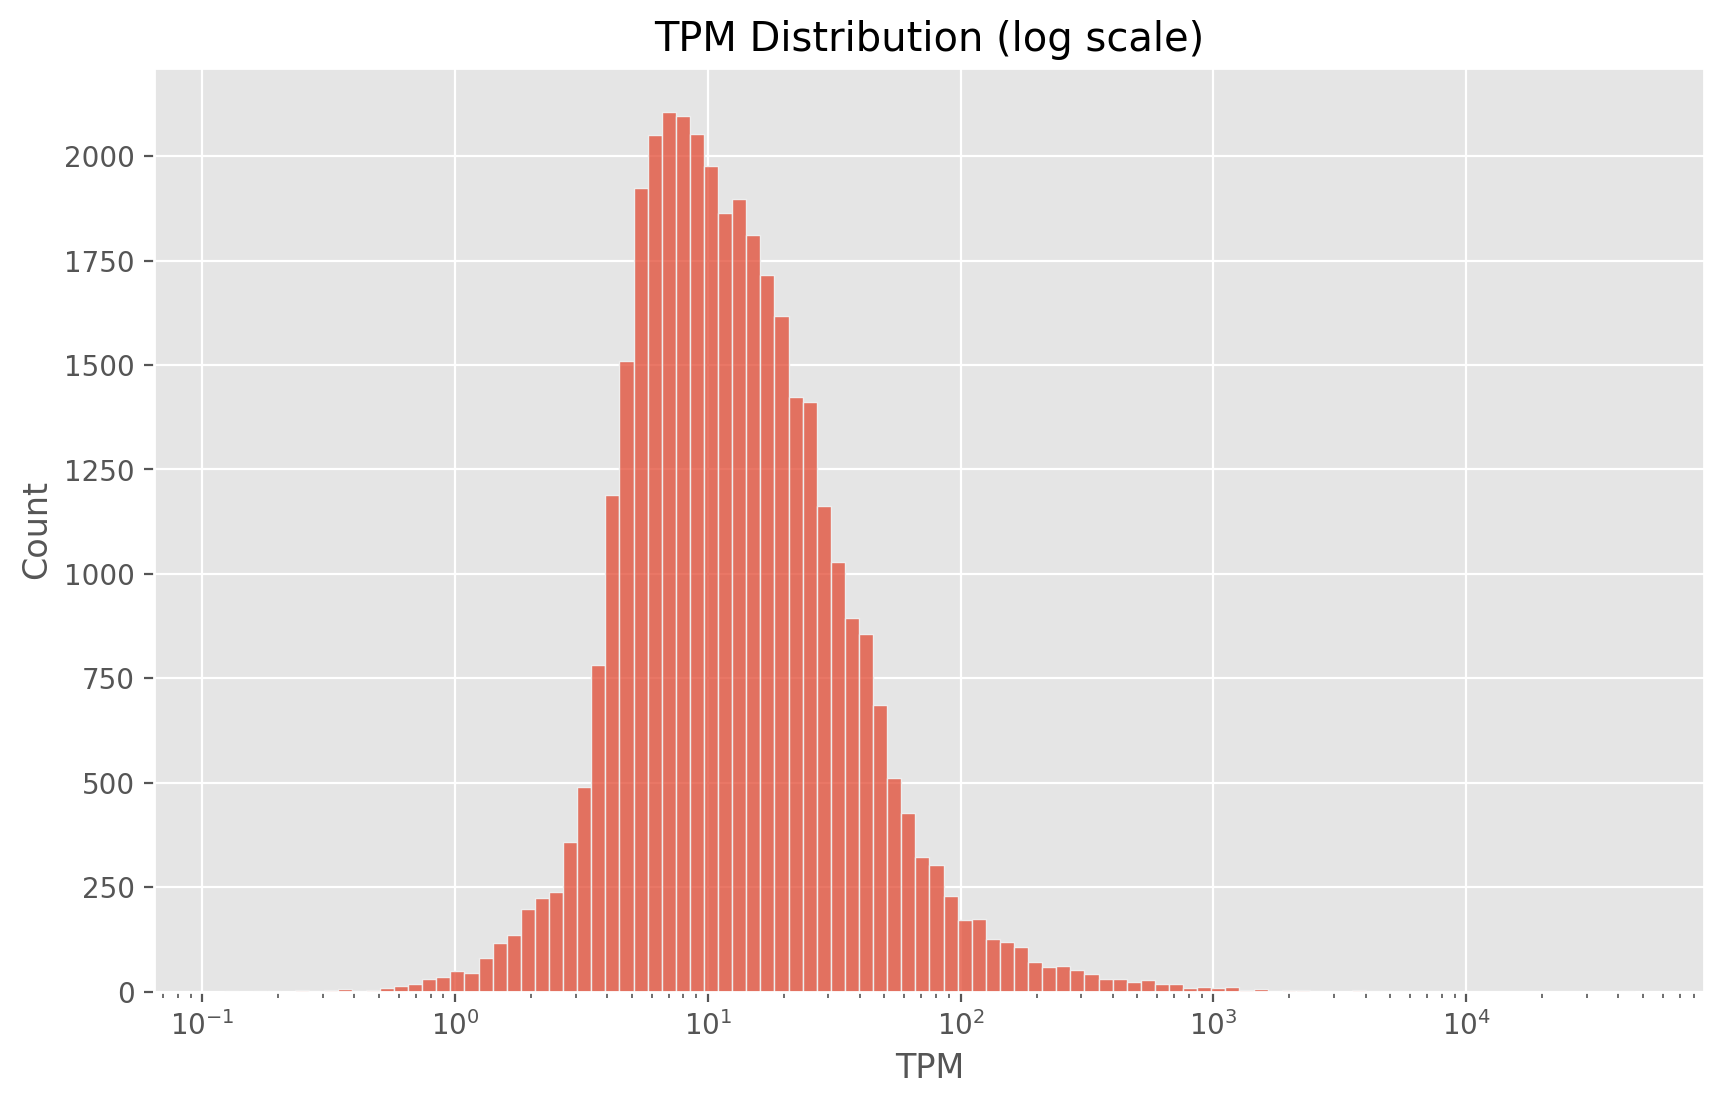

<Figure size 1000x600 with 0 Axes>

/tmp/ipykernel_1348972/223982968.py:375: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='cog_category', data=cog_counts, palette='viridis')


<Axes: xlabel='count', ylabel='cog_category'>

Text(0.5, 1.0, 'Top 10 COG Categories')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Category')

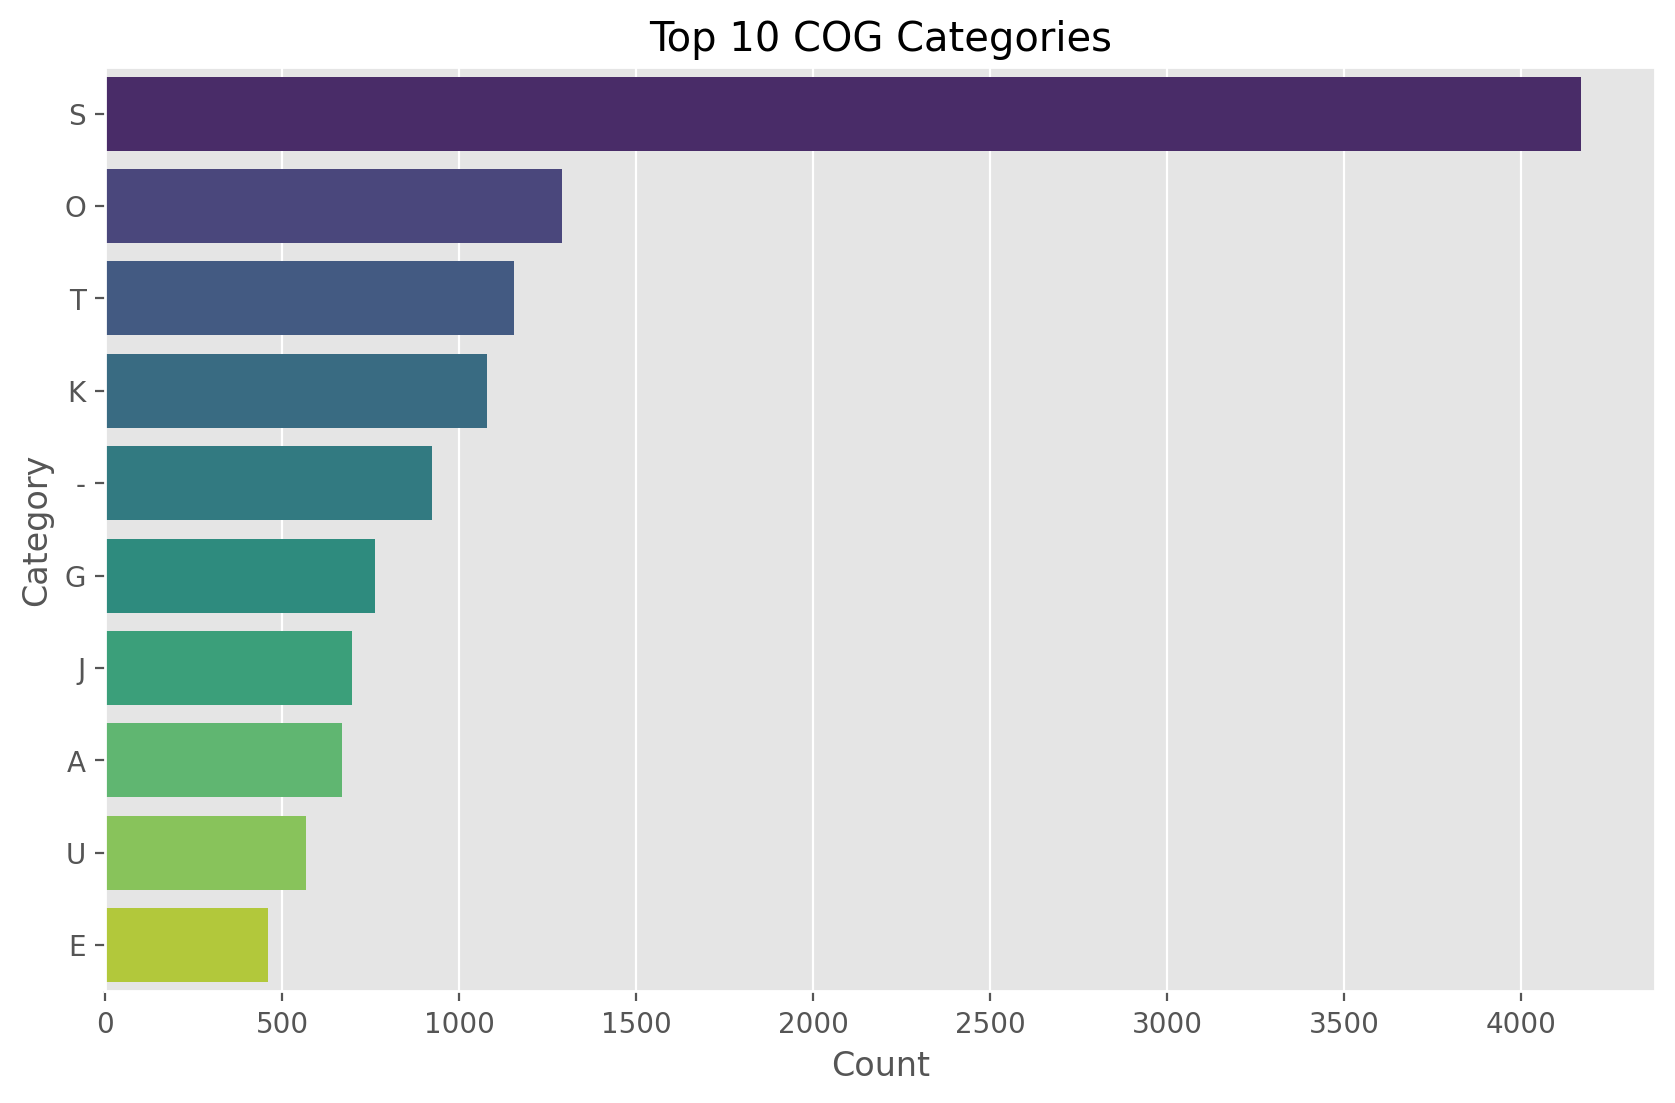

In [40]:
# %% [markdown]
# # Transcriptomics Sample Database Builder
# Builds a DuckDB database from pipeline outputs for a single sample

# %%
import duckdb
import json
import pandas as pd
from Bio import SeqIO
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

# %% [markdown]
# ## Configuration
# Set your sample ID and paths

# %%
# SRA_ID = "SRR12068547"
SRA_ID = "ERR2040767"
SAMPLE_DIR = Path("/mnt/data3/planter_outputs") / SRA_ID
DUCKDB_PATH = SAMPLE_DIR / f"{SRA_ID}.duckdb"

# Paths to key files
PATHS = {
    "stats_json": SAMPLE_DIR / f"{SRA_ID}_stats.json",
    "transcripts_fasta": SAMPLE_DIR / "rnaspades" / f"{SRA_ID}_transcripts_renamed.fasta",
    "quant_sf": SAMPLE_DIR / "quants" / "quant.sf",
    "eggnog_annot": SAMPLE_DIR / "eggnog" / f"{SRA_ID}.emapper.annotations",
    "transdecoder_pep": SAMPLE_DIR / "transdecoder" / f"{SRA_ID}.pep",
    "rrna_stats": SAMPLE_DIR / "illumina" / "rrna_filtered" / f"{SRA_ID}_rRNA_filter.stats"
}

# %% [markdown]
# ## Initialize DuckDB Database

# %%
# Create or connect to DuckDB
conn = duckdb.connect(str(DUCKDB_PATH))

# %% [markdown]
# ## 1. Create Tables Schema

# %%
# Drop existing tables in dependency order
_ = conn.execute("DROP TABLE IF EXISTS quantification")
_ = conn.execute("DROP TABLE IF EXISTS eggnog_annotations") 
_ = conn.execute("DROP TABLE IF EXISTS proteins")
_ = conn.execute("DROP TABLE IF EXISTS transcripts")  # Now safe to drop
_ = conn.execute("DROP TABLE IF EXISTS sample_metadata")

# Create tables
_ = conn.execute("""
CREATE TABLE sample_metadata (
    sra_id TEXT PRIMARY KEY,
    organism TEXT,
    sequencing_type TEXT,
    total_reads_raw INTEGER,
    total_reads_processed INTEGER,
    rrna_filtered_reads INTEGER,
    assembly_stats JSON,
    processing_date DATE
)
""")

_ = conn.execute("""
CREATE TABLE transcripts (
    seqhash TEXT PRIMARY KEY,
    sequence TEXT,
    length INTEGER,
    is_hard_filtered BOOLEAN,
    assembly_metrics JSON
)
""")

_ = conn.execute("""
CREATE TABLE quantification (
    seqhash TEXT PRIMARY KEY,
    tpm FLOAT,
    num_reads INTEGER,
    effective_length FLOAT,
    transcript_length INTEGER,
    FOREIGN KEY (seqhash) REFERENCES transcripts(seqhash)
)
""")

_ = conn.execute("""
CREATE TABLE eggnog_annotations (
    protein_seqhash TEXT PRIMARY KEY,
    transcript_seqhash TEXT,
    cog_category TEXT,
    go_terms TEXT[],
    kegg_pathways TEXT[],
    predicted_gene_name TEXT,
    FOREIGN KEY (transcript_seqhash) REFERENCES transcripts(seqhash),
)
""")

_ = conn.execute("""
CREATE TABLE proteins (
    protein_id TEXT PRIMARY KEY,
    seqhash TEXT,
    peptide_sequence TEXT,
    cds_start INTEGER,
    cds_end INTEGER,
    FOREIGN KEY (seqhash) REFERENCES transcripts(seqhash)
)
""")

# %% [markdown]
# ## 2. Load Metadata

# %%
# Load stats JSON
with open(PATHS["stats_json"]) as f:
    stats = json.load(f)

# Parse rRNA stats
rrna_stats = pd.read_csv(PATHS["rrna_stats"], sep="\t", comment="#")
rrna_filtered = int(rrna_stats.columns[1].split('/')[0])  # From '858881/14926556'

# Insert metadata
_ = conn.execute(f"""
INSERT INTO sample_metadata VALUES (
    '{SRA_ID}',
    '{stats["organism"]}',
    '{stats["Sequencing Type"]}',
    {stats["Total Reads (Before)"]},
    {stats["Total Reads (After)"]},
    {rrna_filtered},
    json_object(
        'num_transcripts', {stats["Number of Transcripts"]},
        'n50', {stats["N50"]},
        'exn50', {stats["ExN50"]},
        'total_length', {stats["Total Assembly Length"]}
    ),
    CURRENT_DATE
)
""")

# %% [markdown]
# ## 3. Load Transcripts

# %%
# Parse FASTA files
transcripts = []
for rec in SeqIO.parse(PATHS["transcripts_fasta"], "fasta"):
    transcripts.append((
        rec.id,
        str(rec.seq),
        len(rec.seq),
        False,  # Assuming renamed fasta isn't hard-filtered
        json.dumps({"source_file": str(PATHS["transcripts_fasta"])})
    ))

# Bulk insert
_ = conn.executemany(
    "INSERT INTO transcripts VALUES (?, ?, ?, ?, ?)",
    transcripts
)

# %% [markdown]
# ## 4. Load Quantification Data

# %%
# Load Salmon quant.sf
quant_df = pd.read_csv(PATHS["quant_sf"], sep="\t")
quant_df = quant_df.rename(columns={
    "Name": "seqhash",
    "TPM": "tpm",
    "NumReads": "num_reads",
    "EffectiveLength": "effective_length",
    "Length": "transcript_length"
})

# Modify the quantification table schema to track the relationship:
_ = conn.execute("DROP TABLE IF EXISTS quantification")
_ = conn.execute("""
CREATE TABLE quantification (
    seqhash TEXT PRIMARY KEY,
    original_seqhash TEXT,
    tpm FLOAT,
    num_reads INTEGER,
    effective_length FLOAT,
    transcript_length FLOAT,
    FOREIGN KEY (original_seqhash) REFERENCES transcripts(seqhash)
)
""")


# # Insert using the expanded dataframe
# conn.register("expanded_quants", expanded_quants)
# # First, let's verify our column types
# print("Column types:", expanded_quants.dtypes)

# # Then modify the insert to be explicit about types
# conn.register("expanded_quants", expanded_quants)
# _ = # conn.execute("""
# INSERT INTO quantification
# SELECT 
#     seqhash::TEXT,
#     original_seqhash::TEXT,
#     tpm::FLOAT,
#     num_reads::INTEGER,
#     effective_length::FLOAT,
#     transcript_length::INTEGER
# FROM expanded_quants
# """)


# # Insert using pandas
conn.register("quant_df", quant_df)
_ = conn.execute("""
INSERT INTO quantification 
    (seqhash, tpm, num_reads, effective_length, transcript_length)
SELECT 
    seqhash,
    tpm,
    num_reads,
    effective_length,
    transcript_length 
FROM quant_df
""")

# %% [markdown]
# ## 5. Load eggNOG Annotations

# %%
# Parse eggNOG annotations
eggnog_df = pd.read_csv(PATHS["eggnog_annot"], sep='\t', comment='#', header=None)
eggnog_df.columns = [
    'query', 'seed_ortholog', 'evalue', 'score', 'eggNOG_OGs', 'max_annot_lvl',
    'COG_category', 'Description', 'Preferred_name', 'GOs', 'EC', 'KEGG_ko',
    'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction', 'KEGG_rclass', 'BRITE',
    'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs'
]

# Extract protein and transcript IDs
eggnog_df['protein_seqhash'] = eggnog_df['query']  # Original protein ID (xxxx.p2)
eggnog_df['transcript_seqhash'] = eggnog_df['query'].str.split('.').str[0]  # Parent transcript

# Clean other fields
eggnog_df['GOs'] = eggnog_df['GOs'].str.split(',')
eggnog_df['KEGG_Pathway'] = eggnog_df['KEGG_Pathway'].str.split(',')
eggnog_df['COG_category'] = eggnog_df['COG_category'].str.replace(r'[\s\|]', '', regex=True)

# Insert into database
conn.register("eggnog_df", eggnog_df)
_ = conn.execute("""
INSERT INTO eggnog_annotations (
    protein_seqhash,
    transcript_seqhash,
    cog_category,
    go_terms,
    kegg_pathways,
    predicted_gene_name
)
SELECT 
    protein_seqhash,
    transcript_seqhash,
    COG_category,
    GOs,
    KEGG_Pathway,
    Preferred_name
FROM eggnog_df
""")

# %% [markdown]
# ## 6. Load Protein Predictions

# %%
# Parse TransDecoder PEP
proteins = []
for rec in SeqIO.parse(PATHS["transdecoder_pep"], "fasta"):
    # Extract transcript ID from header: TRINITY_DN0_c0_g1_i1.p1
    seqhash = rec.id.split("|")[0].split(".")[0]  
    proteins.append((
        rec.id,
        seqhash,
        str(rec.seq),
        None,  # Will update from BED
        None
    ))

_ = conn.executemany(
    "INSERT INTO proteins (protein_id, seqhash, peptide_sequence, cds_start, cds_end) VALUES (?, ?, ?, ?, ?)",
    proteins
)

# Update CDS coordinates from BED
bed_path = SAMPLE_DIR / "transdecoder" / f"{SRA_ID}.bed"
if bed_path.exists():
    bed_df = pd.read_csv(bed_path, sep="\t", header=None, skiprows=1,
                        names=["seqhash", "start", "end", "protein_id", "score", "strand"])
    
    for _, row in bed_df.iterrows():
        _ = conn.execute(f"""
            UPDATE proteins
            SET cds_start = {row['start']}, cds_end = {row['end']}
            WHERE protein_id = '{row['protein_id']}'
        """)

# %% [markdown]
# ## 7. Add Indexes

# %%
# Create performance indexes
_ = conn.execute("CREATE INDEX idx_seqhash ON transcripts(seqhash)")
_ = conn.execute("CREATE INDEX idx_tpm ON quantification(tpm)")
_ = conn.execute("CREATE INDEX idx_cog ON eggnog_annotations(cog_category)")

# %% [markdown]
# ## 8. Validation Checks

# %%
# Verify counts match
_ = transcript_count = conn.execute("SELECT COUNT(*) FROM transcripts").fetchone()[0]
_ = quant_count = conn.execute("SELECT COUNT(*) FROM quantification").fetchone()[0]

print(f"Transcripts: {transcript_count}")
print(f"Quant entries: {quant_count}")

assert transcript_count == quant_count, "Mismatch between transcripts and quantification data"

# Check metadata
_ = metadata = conn.execute("SELECT * FROM sample_metadata").df()
display(metadata)

# %%
# Get top 10 expressed transcripts with annotations
_ = top_expr = conn.execute("""
SELECT 
    t.seqhash,
    t.length,
    q.tpm,
    e.cog_category,
    e.go_terms
FROM transcripts t
JOIN quantification q USING (seqhash)
LEFT JOIN eggnog_annotations e 
    ON e.transcript_seqhash = t.seqhash  -- Changed join condition
ORDER BY q.tpm DESC
""").df()

display(top_expr)

# %% [markdown]
# ## 10. Basic Visualization

# %%
# TPM distribution
plt.figure(figsize=(10,6))
_ = tpm_data = conn.execute("SELECT tpm FROM quantification").df()
sns.histplot(tpm_data, x='tpm', bins=100, log_scale=True)
plt.title('TPM Distribution (log scale)')
plt.xlabel('TPM')
plt.ylabel('Count')
plt.show()

# COG categories
_ = cog_counts = conn.execute("""
SELECT cog_category, COUNT(*) AS count
FROM eggnog_annotations
GROUP BY cog_category
ORDER BY count DESC
LIMIT 10
""").df()

plt.figure(figsize=(10,6))
sns.barplot(x='count', y='cog_category', data=cog_counts, palette='viridis')
plt.title('Top 10 COG Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# %%
# Close connection
conn.close()

In [ ]:
conn = duckdb.connect(str(DUCKDB_PATH))

# List all tables
display(conn.execute("SHOW TABLES").df())

# See table schema
display(conn.execute("DESCRIBE sample_metadata").df())
display(conn.execute("DESCRIBE transcripts").df())
display(conn.execute("DESCRIBE quantification").df())
display(conn.execute("DESCRIBE proteins").df())
display(conn.execute("DESCRIBE eggnog_annotations").df())


,name
0,eggnog_annotations
1,proteins
2,quantification
3,sample_metadata
4,transcripts


,column_name,column_type,null,key,default,extra
0,protein_id,VARCHAR,NO,PRI,None,None
1,seqhash,VARCHAR,YES,None,None,None
2,peptide_sequence,VARCHAR,YES,None,None,None
3,cds_start,INTEGER,YES,None,None,None
4,cds_end,INTEGER,YES,None,None,None


,column_name,column_type,null,key,default,extra
0,seqhash,VARCHAR,NO,PRI,None,None
1,original_seqhash,VARCHAR,YES,None,None,None
2,tpm,FLOAT,YES,None,None,None
3,num_reads,INTEGER,YES,None,None,None
4,effective_length,FLOAT,YES,None,None,None
5,transcript_length,FLOAT,YES,None,None,None


,column_name,column_type,null,key,default,extra
0,sra_id,VARCHAR,NO,PRI,None,None
1,organism,VARCHAR,YES,None,None,None
2,sequencing_type,VARCHAR,YES,None,None,None
3,total_reads_raw,INTEGER,YES,None,None,None
4,total_reads_processed,INTEGER,YES,None,None,None
5,rrna_filtered_reads,INTEGER,YES,None,None,None
6,assembly_stats,JSON,YES,None,None,None
7,processing_date,DATE,YES,None,None,None


,column_name,column_type,null,key,default,extra
0,seqhash,VARCHAR,NO,PRI,None,None
1,sequence,VARCHAR,YES,None,None,None
2,length,INTEGER,YES,None,None,None
3,is_hard_filtered,BOOLEAN,YES,None,None,None
4,assembly_metrics,JSON,YES,None,None,None


,column_name,column_type,null,key,default,extra
0,protein_seqhash,VARCHAR,NO,PRI,None,None
1,transcript_seqhash,VARCHAR,YES,None,None,None
2,cog_category,VARCHAR,YES,None,None,None
3,go_terms,VARCHAR[],YES,None,None,None
4,kegg_pathways,VARCHAR[],YES,None,None,None
5,predicted_gene_name,VARCHAR,YES,None,None,None


In [48]:
conn = duckdb.connect(str(DUCKDB_PATH))

# Find highly expressed unannotated transcripts
conn.execute("""
SELECT q.seqhash, q.tpm, t.length
FROM quantification q
JOIN transcripts t USING (seqhash)
LEFT JOIN eggnog_annotations e ON e.transcript_seqhash = q.seqhash
WHERE e.cog_category IS NULL
ORDER BY q.tpm DESC
LIMIT 10
""").df()

# Find transcripts with both high expression and annotations
conn.execute("""
SELECT t.seqhash, q.tpm, e.cog_category, e.kegg_pathways
FROM transcripts t
JOIN quantification q USING (seqhash)
JOIN eggnog_annotations e ON e.transcript_seqhash = t.seqhash
WHERE q.tpm > 100
AND e.kegg_pathways IS NOT NULL
ORDER BY q.tpm DESC
""").df()

# Compare annotation coverage
conn.execute("""
SELECT 
    CASE WHEN e.cog_category IS NULL THEN 'Unannotated' ELSE 'Annotated' END AS status,
    AVG(q.tpm) AS avg_tpm,
    COUNT(*) AS count
FROM quantification q
LEFT JOIN eggnog_annotations e ON e.transcript_seqhash = q.seqhash
GROUP BY status
""").df()



,seqhash,tpm,length
0,v1_DLS_bb4cc80aadf2876848e9eacf02c191a4d90a5c7...,46137.035156,617
1,v1_DLS_689307211579fe9955a2aff027714303744f071...,4244.320312,962
2,v1_DLS_8a9d0750e31aaa57ee4f4c83a01d9a7271567df...,3928.480469,1645
3,v1_DLS_ba9e6bf523bc21ccbff02c8b5957736d95a3490...,2814.059082,230
4,v1_DLS_c591415284c242182deffca0212747df894104d...,2530.742188,422
5,v1_DLS_b475e22b17e5ff368792bdc606ca43f824d1015...,2338.667236,695
6,v1_DLS_e847bc74cae093b510a47205f530418934ec3d4...,1978.943115,647
7,v1_DLS_a45f3d5283ba60130bf70829cf556bb9903b67e...,1595.585205,1194
8,v1_DLS_8e98723368c9433607b74f7e4795065af89f804...,1457.109497,650
9,v1_DLS_0a807d94d7a5c156401cc7a31df62d2ed4f87d6...,1254.257935,1073


,seqhash,tpm,cog_category,kegg_pathways
0,v1_DLS_dd6bbc8d35fe64503461c0f6db8c99ce58ddaad...,5492.479492,E,"[ko00630, ko00710, ko01100, ko01120, ko01200, ..."
1,v1_DLS_dd6bbc8d35fe64503461c0f6db8c99ce58ddaad...,5492.479492,E,"[ko00630, ko00710, ko01100, ko01120, ko01200, ..."
2,v1_DLS_2006ba2f71f368885197d76c695017d83a98b52...,5054.346191,C,"[ko00196, ko01100, map00196, map01100]"
3,v1_DLS_694036c272a441f44f377959dbfdb69e0e1486a...,4015.652100,S,[-]
4,v1_DLS_d10c1ad6eefcce55ce6b1086fd8cb179a7657d5...,3764.564453,O,[-]
...,...,...,...,...
884,v1_DLS_3ff1d9557803e914694f498aea29d243760f61a...,100.318535,U,[-]
885,v1_DLS_801579779fe589831c5d4e75a5980eaeb3db755...,100.292953,S,"[ko00130, ko01100, ko01110, map00130, map01100..."
886,v1_DLS_03f4216161bd7ae9a34966d17d940899f376c1e...,100.281334,S,[-]
887,v1_DLS_24cfddbaf3ea4f0c8af2f6da575c213f6cf19ed...,100.264427,T,"[ko00270, ko00330, ko01100, map00270, map00330..."


,status,avg_tpm,count
0,Annotated,34.816544,15618
1,Unannotated,21.301152,22371


In [53]:
import duckdb
import json
import pandas as pd
from Bio import SeqIO
from pathlib import Path
from typing import Dict, Any

class PlanterDBBuilder:
    def __init__(self, sra_id: str, sample_dir: Path):
        self.sra_id = sra_id
        self.sample_dir = sample_dir
        self.db_path = sample_dir / f"{sra_id}.duckdb"
        self.paths = self._get_paths()
        self.conn = duckdb.connect(str(self.db_path))

    def _get_paths(self) -> Dict[str, Path]:
        """Build path configuration for pipeline outputs"""
        return {
            "stats_json": self.sample_dir / f"{self.sra_id}_stats.json",
            "transcripts_fasta": self.sample_dir / "rnaspades" / f"{self.sra_id}_transcripts_renamed.fasta",
            "quant_sf": self.sample_dir / "quants" / "quant.sf",
            "eggnog_annot": self.sample_dir / "eggnog" / f"{self.sra_id}.emapper.annotations",
            "transdecoder_pep": self.sample_dir / "transdecoder" / f"{self.sra_id}.pep",
            "rrna_stats": self.sample_dir / "illumina" / "rrna_filtered" / f"{self.sra_id}_rRNA_filter.stats"
        }

    def create_schema(self) -> None:
        """Initialize database schema with proper table structure"""
        schema_sql = """
        DROP TABLE IF EXISTS quantification;
        DROP TABLE IF EXISTS eggnog_annotations;
        DROP TABLE IF EXISTS proteins;
        DROP TABLE IF EXISTS transcripts;
        DROP TABLE IF EXISTS sample_metadata;

        CREATE TABLE sample_metadata (
            sra_id TEXT PRIMARY KEY,
            organism TEXT,
            sequencing_type TEXT,
            total_reads_raw INTEGER,
            total_reads_processed INTEGER,
            rrna_filtered_reads INTEGER,
            assembly_stats JSON,
            processing_date DATE
        );

        CREATE TABLE transcripts (
            seqhash TEXT PRIMARY KEY,
            sequence TEXT,
            length INTEGER,
            is_hard_filtered BOOLEAN,
            assembly_metrics JSON
        );

        CREATE TABLE quantification (
            seqhash TEXT PRIMARY KEY,
            tpm FLOAT,
            num_reads INTEGER,
            effective_length FLOAT,
            transcript_length INTEGER,
            FOREIGN KEY (seqhash) REFERENCES transcripts(seqhash)
        );

        CREATE TABLE eggnog_annotations (
            protein_seqhash TEXT PRIMARY KEY,
            transcript_seqhash TEXT,
            cog_category TEXT,
            go_terms TEXT[],
            kegg_pathways TEXT[],
            predicted_gene_name TEXT,
            FOREIGN KEY (transcript_seqhash) REFERENCES transcripts(seqhash)
        );

        CREATE TABLE proteins (
            protein_id TEXT PRIMARY KEY,
            seqhash TEXT,
            peptide_sequence TEXT,
            cds_start INTEGER,
            cds_end INTEGER,
            FOREIGN KEY (seqhash) REFERENCES transcripts(seqhash)
        );
        """
        self.conn.execute(schema_sql)

    def load_sample_metadata(self) -> None:
        """Load sample metadata from pipeline output files"""
        with open(self.paths["stats_json"]) as f:
            stats = json.load(f)

        rrna_stats = pd.read_csv(self.paths["rrna_stats"], sep="\t", comment="#")
        rrna_filtered = int(rrna_stats.columns[1].split('/')[0])

        self.conn.execute("""
            INSERT INTO sample_metadata VALUES (
                ?, ?, ?, ?, ?, ?, ?, CURRENT_DATE
            )
        """, [
            self.sra_id,
            stats["organism"],
            stats["Sequencing Type"],
            stats["Total Reads (Before)"],
            stats["Total Reads (After)"],
            rrna_filtered,
            json.dumps({
                'num_transcripts': stats["Number of Transcripts"],
                'n50': stats["N50"],
                'exn50': stats["ExN50"],
                'total_length': stats["Total Assembly Length"]
            })
        ])

    def load_transcripts(self) -> None:
        """Load transcript sequences and metadata from FASTA"""
        transcripts = [
            (
                rec.id,
                str(rec.seq),
                len(rec.seq),
                False,
                json.dumps({"source_file": str(self.paths["transcripts_fasta"])})
            )
            for rec in SeqIO.parse(self.paths["transcripts_fasta"], "fasta")
        ]
        
        self.conn.executemany(
            "INSERT INTO transcripts VALUES (?, ?, ?, ?, ?)",
            transcripts
        )

    def load_quantification(self) -> None:
        """Load Salmon quantification data"""
        quant_df = pd.read_csv(self.paths["quant_sf"], sep="\t").rename(columns={
            "Name": "seqhash",
            "TPM": "tpm",
            "NumReads": "num_reads",
            "EffectiveLength": "effective_length",
            "Length": "transcript_length"
        })
        
        self.conn.register("quant_df", quant_df)
        self.conn.execute("""
            INSERT INTO quantification 
            SELECT seqhash, tpm, num_reads, effective_length, transcript_length
            FROM quant_df
        """)

    def load_eggnog_annotations(self) -> None:
        """Process and load eggNOG functional annotations"""
        eggnog_df = pd.read_csv(
            self.paths["eggnog_annot"],
            sep='\t',
            comment='#',
            header=None,
            names=[
                'query', 'seed_ortholog', 'evalue', 'score', 'eggNOG_OGs', 'max_annot_lvl',
                'COG_category', 'Description', 'Preferred_name', 'GOs', 'EC', 'KEGG_ko',
                'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction', 'KEGG_rclass', 'BRITE',
                'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs'
            ]
        )

        # Process annotation data
        eggnog_df = (
            eggnog_df
            .assign(
                protein_seqhash=lambda df: df['query'],
                transcript_seqhash=lambda df: df['query'].str.split('.').str[0],
                GOs=lambda df: df['GOs'].str.split(','),
                KEGG_Pathway=lambda df: df['KEGG_Pathway'].str.split(','),
                COG_category=lambda df: df['COG_category'].str.replace(r'[\s\|]', '', regex=True)
            )
            [['protein_seqhash', 'transcript_seqhash', 'COG_category', 
              'GOs', 'KEGG_Pathway', 'Preferred_name']]
        )

        self.conn.register("eggnog_df", eggnog_df)
        self.conn.execute("""
            INSERT INTO eggnog_annotations
            SELECT * FROM eggnog_df
        """)

    def load_proteins(self) -> None:
        """Load protein predictions and CDS coordinates"""
        # Load protein sequences
        proteins = [
            (
                rec.id,
                rec.id.split(".")[0],  # Parent transcript ID
                str(rec.seq),
                None,
                None
            )
            for rec in SeqIO.parse(self.paths["transdecoder_pep"], "fasta")
        ]
        
        self.conn.executemany(
            "INSERT INTO proteins (protein_id, seqhash, peptide_sequence, cds_start, cds_end) VALUES (?, ?, ?, ?, ?)",
            proteins
        )

        # Update CDS coordinates from BED
        bed_path = self.sample_dir / "transdecoder" / f"{self.sra_id}.bed"
        if bed_path.exists():
            bed_df = pd.read_csv(
                bed_path,
                sep="\t",
                header=None,
                skiprows=1,
                names=["seqhash", "start", "end", "protein_id", "score", "strand"]
            )
            
            # Convert numpy ints to Python ints and prepare parameters
            cds_updates = [
                (int(row['start']), int(row['end']), row['protein_id'])
                for _, row in bed_df.iterrows()
            ]
            
            # Use executemany for batch updates
            self.conn.executemany("""
                UPDATE proteins
                SET cds_start = ?, cds_end = ?
                WHERE protein_id = ?
            """, cds_updates)
            
    def create_indexes(self) -> None:
        """Create performance indexes"""
        self.conn.execute("CREATE INDEX idx_seqhash ON transcripts(seqhash)")
        self.conn.execute("CREATE INDEX idx_tpm ON quantification(tpm)")
        self.conn.execute("CREATE INDEX idx_cog ON eggnog_annotations(cog_category)")

    def validate(self) -> None:
        """Run data integrity checks"""
        transcript_count = self.conn.execute("SELECT COUNT(*) FROM transcripts").fetchone()[0]
        quant_count = self.conn.execute("SELECT COUNT(*) FROM quantification").fetchone()[0]
        
        if transcript_count != quant_count:
            raise ValueError(f"Transcript count mismatch: {transcript_count} vs {quant_count}")

    def build(self) -> None:
        """Orchestrate full database build process"""
        steps = [
            self.create_schema,
            self.load_sample_metadata,
            self.load_transcripts,
            self.load_quantification,
            self.load_eggnog_annotations,
            self.load_proteins,
            self.create_indexes,
            self.validate
        ]
        
        for step in steps:
            step()

        self.conn.close()

In [54]:
sample_dir = Path("/mnt/data3/planter_outputs") / "SRR12068547"
builder = PlanterDBBuilder("SRR12068547", sample_dir)
builder.build()


NotImplementedException: Not implemented Error: Unable to transform python value of type '<class 'numpy.int64'>' to DuckDB LogicalType